# Analyse Cifar100 runs with various learning rates and batch sizes</h1>
<h3> Time limitied to <span style="color:#Fa5544;">1800</span>s (30min)</h3>

In [158]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess
import os
import seaborn as sns

In [159]:
!ls logs/fixtime/

time_limit1800s


In [160]:
logdir="logs/fixtime/time_limit1800s"

In [161]:
filename_pattern=re.compile(r"cifar_.*\.log")

In [162]:
files=[]
comm = "ls -1 "+logdir
proc = subprocess.Popen(comm.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
for line in iter(proc.stdout.readline,b''):
    m = filename_pattern.match(line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir,line)))
len(files)

204

In [163]:
batch_learn_pattern = re.compile(r"_b(\d+)_l([0-9\.]+)_(\d+)") # Match against file name
output_pattern = re.compile(r"^(\d+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)\s+([0-9\.]+)")

In [164]:
remove_str="[J"
def readfile(filename,debug=False):
    filename = filename.strip(" \n")
    if debug: print "FILE",filename
    batch = 0
    learn = 0
    ind = 0 # DF row conter
    run = 0
    m = batch_learn_pattern.search(filename)
    if m:
        batch = int(m.group(1))
        learn = float(m.group(2))
        run = int(m.group(3))
    if debug: print "BS,LR,run:",batch,learn,run
    with open(filename,"r") as f:
        lines = f.readlines()
        epoch = 0    
        loss = 0
        acc = 0
        time = 0
        df = pd.DataFrame(data=None,columns=["run","batch","lr","epoch","loss","acc","time"])
        for line in lines:
            s = line.strip('\n')
            s = s.replace(remove_str,"")
            m = output_pattern.match(s)
            if m:
                epoch = int(m.group(1))
                loss = float(m.group(3))
                acc = float(m.group(5))
                time = float(m.group(6))
                df.loc[ind] = [run, batch,learn,epoch,loss,acc,time]            
                ind += 1
                if debug: print epoch,loss,acc,time
    return df

In [165]:
df = pd.DataFrame(data=None,columns=["run","batch","lr","epoch","loss","acc","time"])
maxfiles = 3000
i = 0
for file in files:
    df1 = readfile(file, debug=False)
    if len(df1) > 0:
        df = pd.concat([df,df1],ignore_index=True)
    i += 1
    if i > maxfiles:
        break
df.describe()

,run,batch,lr,epoch,loss,acc,time
count,14153.0,14153.000000,14153.000000,14153.000000,14153.000000,14153.000000,14153.000000
mean,0.0,758.253939,0.153723,36.072140,3.482053,0.269391,908.344690
std,0.0,538.222970,0.137961,21.223832,1.633455,0.226486,515.879834
min,0.0,32.000000,0.001000,1.000000,1.425020,0.006369,24.187300
25%,0.0,256.000000,0.025000,18.000000,2.057000,0.020693,464.416000
50%,0.0,768.000000,0.150000,35.000000,3.032930,0.258604,908.471000
75%,0.0,1280.000000,0.300000,54.000000,4.617200,0.495274,1355.850000
max,0.0,1664.000000,0.400000,77.000000,10.697500,0.648534,1801.910000


In [166]:
df.drop(["run"],axis=1,inplace=True)
df.head()

,batch,lr,epoch,loss,acc,time
0,1024.0,0.001,1.0,4.64194,0.010561,24.5996
1,1024.0,0.001,2.0,4.62946,0.009975,48.3339
2,1024.0,0.001,3.0,4.61793,0.010035,72.1301
3,1024.0,0.001,4.0,4.61232,0.009742,95.9209
4,1024.0,0.001,5.0,4.61050,0.009674,119.7080


In [167]:
# Make new column with max epoch for each (batch, lr, run) combination
df_maxepoch = df.copy()
df_maxepoch["max_epoch"] = df_maxepoch.groupby(["batch","lr"])["epoch"].transform(np.max)
df_maxepoch = df_maxepoch.sort_values(by=["batch","lr"],ascending=True)
df_maxepoch.head()

,batch,lr,epoch,loss,acc,time,max_epoch
7138,32.0,0.001,1.0,4.71381,0.009984,51.5573,38.0
7139,32.0,0.001,2.0,5.03831,0.010084,98.6746,38.0
7140,32.0,0.001,3.0,5.48507,0.009984,145.6410,38.0
7141,32.0,0.001,4.0,5.77521,0.009984,192.3660,38.0
7142,32.0,0.001,5.0,5.86843,0.010383,238.6430,38.0


In [168]:
df_maxepoch = df_maxepoch[df_maxepoch["max_epoch"] == df_maxepoch["epoch"]]
df_maxepoch.head()

,batch,lr,epoch,loss,acc,time,max_epoch
7175,32.0,0.001,38.0,2.52985,0.364018,1790.12,38.0
7213,32.0,0.005,38.0,1.62927,0.573882,1796.08,38.0
7250,32.0,0.010,37.0,1.73821,0.550419,1784.63,37.0
7287,32.0,0.025,37.0,1.83320,0.514876,1785.16,37.0
7324,32.0,0.050,37.0,2.15493,0.440895,1776.81,37.0


In [169]:
df_maxepoch.drop(["max_epoch"],axis=1,inplace=True)
df_maxepoch.head()

,batch,lr,epoch,loss,acc,time
7175,32.0,0.001,38.0,2.52985,0.364018,1790.12
7213,32.0,0.005,38.0,1.62927,0.573882,1796.08
7250,32.0,0.010,37.0,1.73821,0.550419,1784.63
7287,32.0,0.025,37.0,1.83320,0.514876,1785.16
7324,32.0,0.050,37.0,2.15493,0.440895,1776.81


In [170]:
df_maxepoch[["batch","epoch"]] = df_maxepoch[["batch","epoch"]].astype(int)
df_maxepoch.dtypes

batch      int64
lr       float64
epoch      int64
loss     float64
acc      float64
time     float64
dtype: object

In [171]:
loss_df = df_maxepoch[['batch','lr','loss']]
acc_df = df_maxepoch[['batch','lr','acc']]
time_df = df_maxepoch[['batch','lr','time']]
epoch_df = df_maxepoch[['batch','lr','epoch']]

In [172]:
def plotHeatMap(df,title=None,cmap=None,yrange=None):
    plt.rcParams['figure.figsize'] = 10,8
    if yrange is None:
        plt.pcolormesh(df,cmap=cmap)
    else:
        plt.pcolormesh(df,cmap=cmap,vmin=yrange[0],vmax=yrange[1])
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    ax = plt.gca()
    ax.tick_params(direction='in', length=0)
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            if df.iloc[y,x] > 0:
                plt.text(x+0.5,y+0.5,'{:.3f}'.format(df.iloc[y,x]),
                         color="black",fontsize=9,
                         horizontalalignment='center',
                         verticalalignment='center',                    
                         bbox={'facecolor':'white','edgecolor':'none', 'alpha':0.2, 'pad':0})
    plt.title(title,fontsize=18)
    plt.xlabel("learning rate",fontsize=12)
    plt.ylabel("minibatch size",fontsize=12)
    plt.colorbar()
    plt.show()

In [173]:
loss_df.head()

,batch,lr,loss
7175,32,0.001,2.52985
7213,32,0.005,1.62927
7250,32,0.010,1.73821
7287,32,0.025,1.83320
7324,32,0.050,2.15493


In [174]:
loss_T = loss_df.pivot_table(index="batch",columns="lr",values="loss")
acc_T = acc_df.pivot_table(index="batch",columns="lr",values="acc")
time_T = time_df.pivot_table(index="batch",columns="lr",values="time")
epoch_T = epoch_df.pivot_table(index="batch",columns="lr",values="epoch")

In [175]:
def getColorList(cmap,n):
    cmap = cm.get_cmap(cmap, n)
    colors = []
    for i in range(cmap.N):
        c = matplotlib.colors.to_hex(cmap(i),keep_alpha=True)
        colors.append(c)
    return colors

In [176]:
def testColorMap(cmap):
    # Fewer bins will result in "coarser" colomap interpolation
    x = np.arange(0, np.pi, 0.1)
    y = np.arange(0, 2*np.pi, 0.1)
    X, Y = np.meshgrid(x, y)
    Z = np.log((X+Y+1)*(X+Y+2))

    plt.rcParams['figure.figsize'] = 5,2
    fig, ax = plt.subplots()
    im = ax.imshow(Z, interpolation='nearest', origin='lower', cmap=cmap)
    ax.set_title("N bins: %s" % 256)
    fig.colorbar(im, ax=ax)
    plt.show()

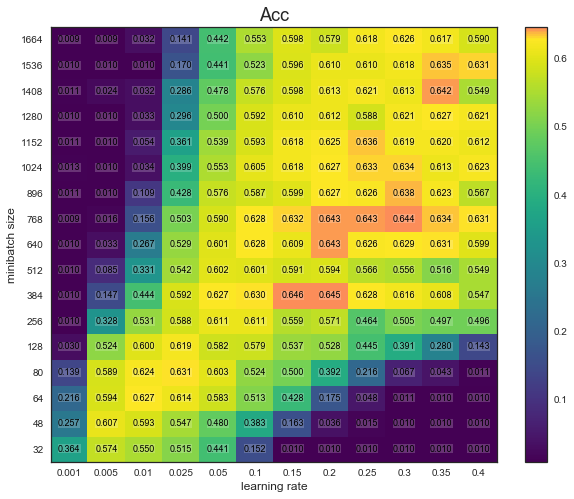

In [183]:
# Combine colormaps
colors1 = getColorList("viridis",40)
colors2 = getColorList("OrRd",5)
colors =  colors1[:] + colors2[2:3]
#print colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=256)
#testColorMap(cmap)
plotHeatMap(acc_T,"Acc",cmap)

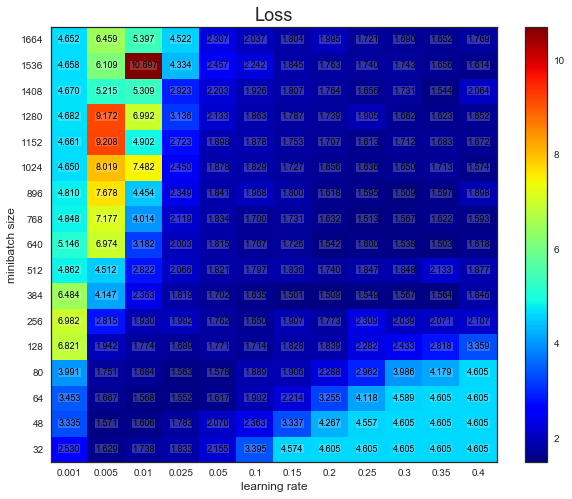

In [178]:
plotHeatMap(loss_T,"Loss","jet")

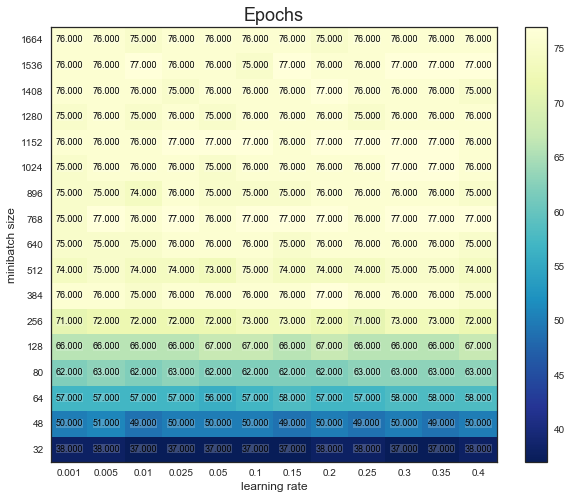

In [179]:
plotHeatMap(epoch_T,"Epochs","YlGnBu_r")

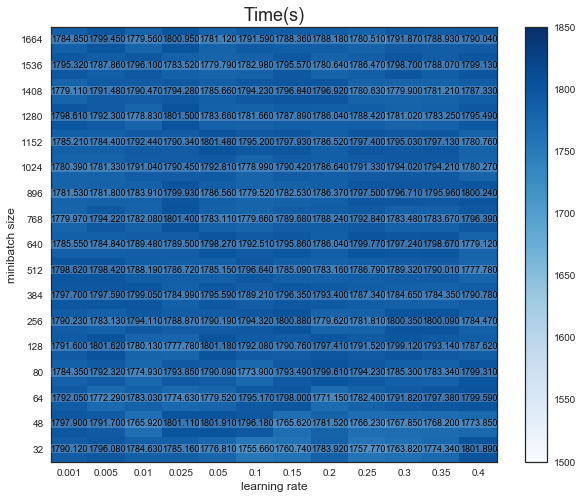

In [180]:
plotHeatMap(time_T,"Time(s)","Blues",yrange=(1500,1850))

In [181]:
df = df.sort_values(by=["batch","lr"],ascending=False)
df[["batch","epoch"]] = df[["batch","epoch"]].astype(int)
df.head()

,batch,lr,epoch,loss,acc,time
6196,1664,0.4,1,4.90033,0.015282,25.5209
6197,1664,0.4,2,4.59959,0.013393,49.0973
6198,1664,0.4,3,4.89306,0.017428,72.7416
6199,1664,0.4,4,5.43534,0.008499,96.4498
6200,1664,0.4,5,5.33495,0.010045,120.1460


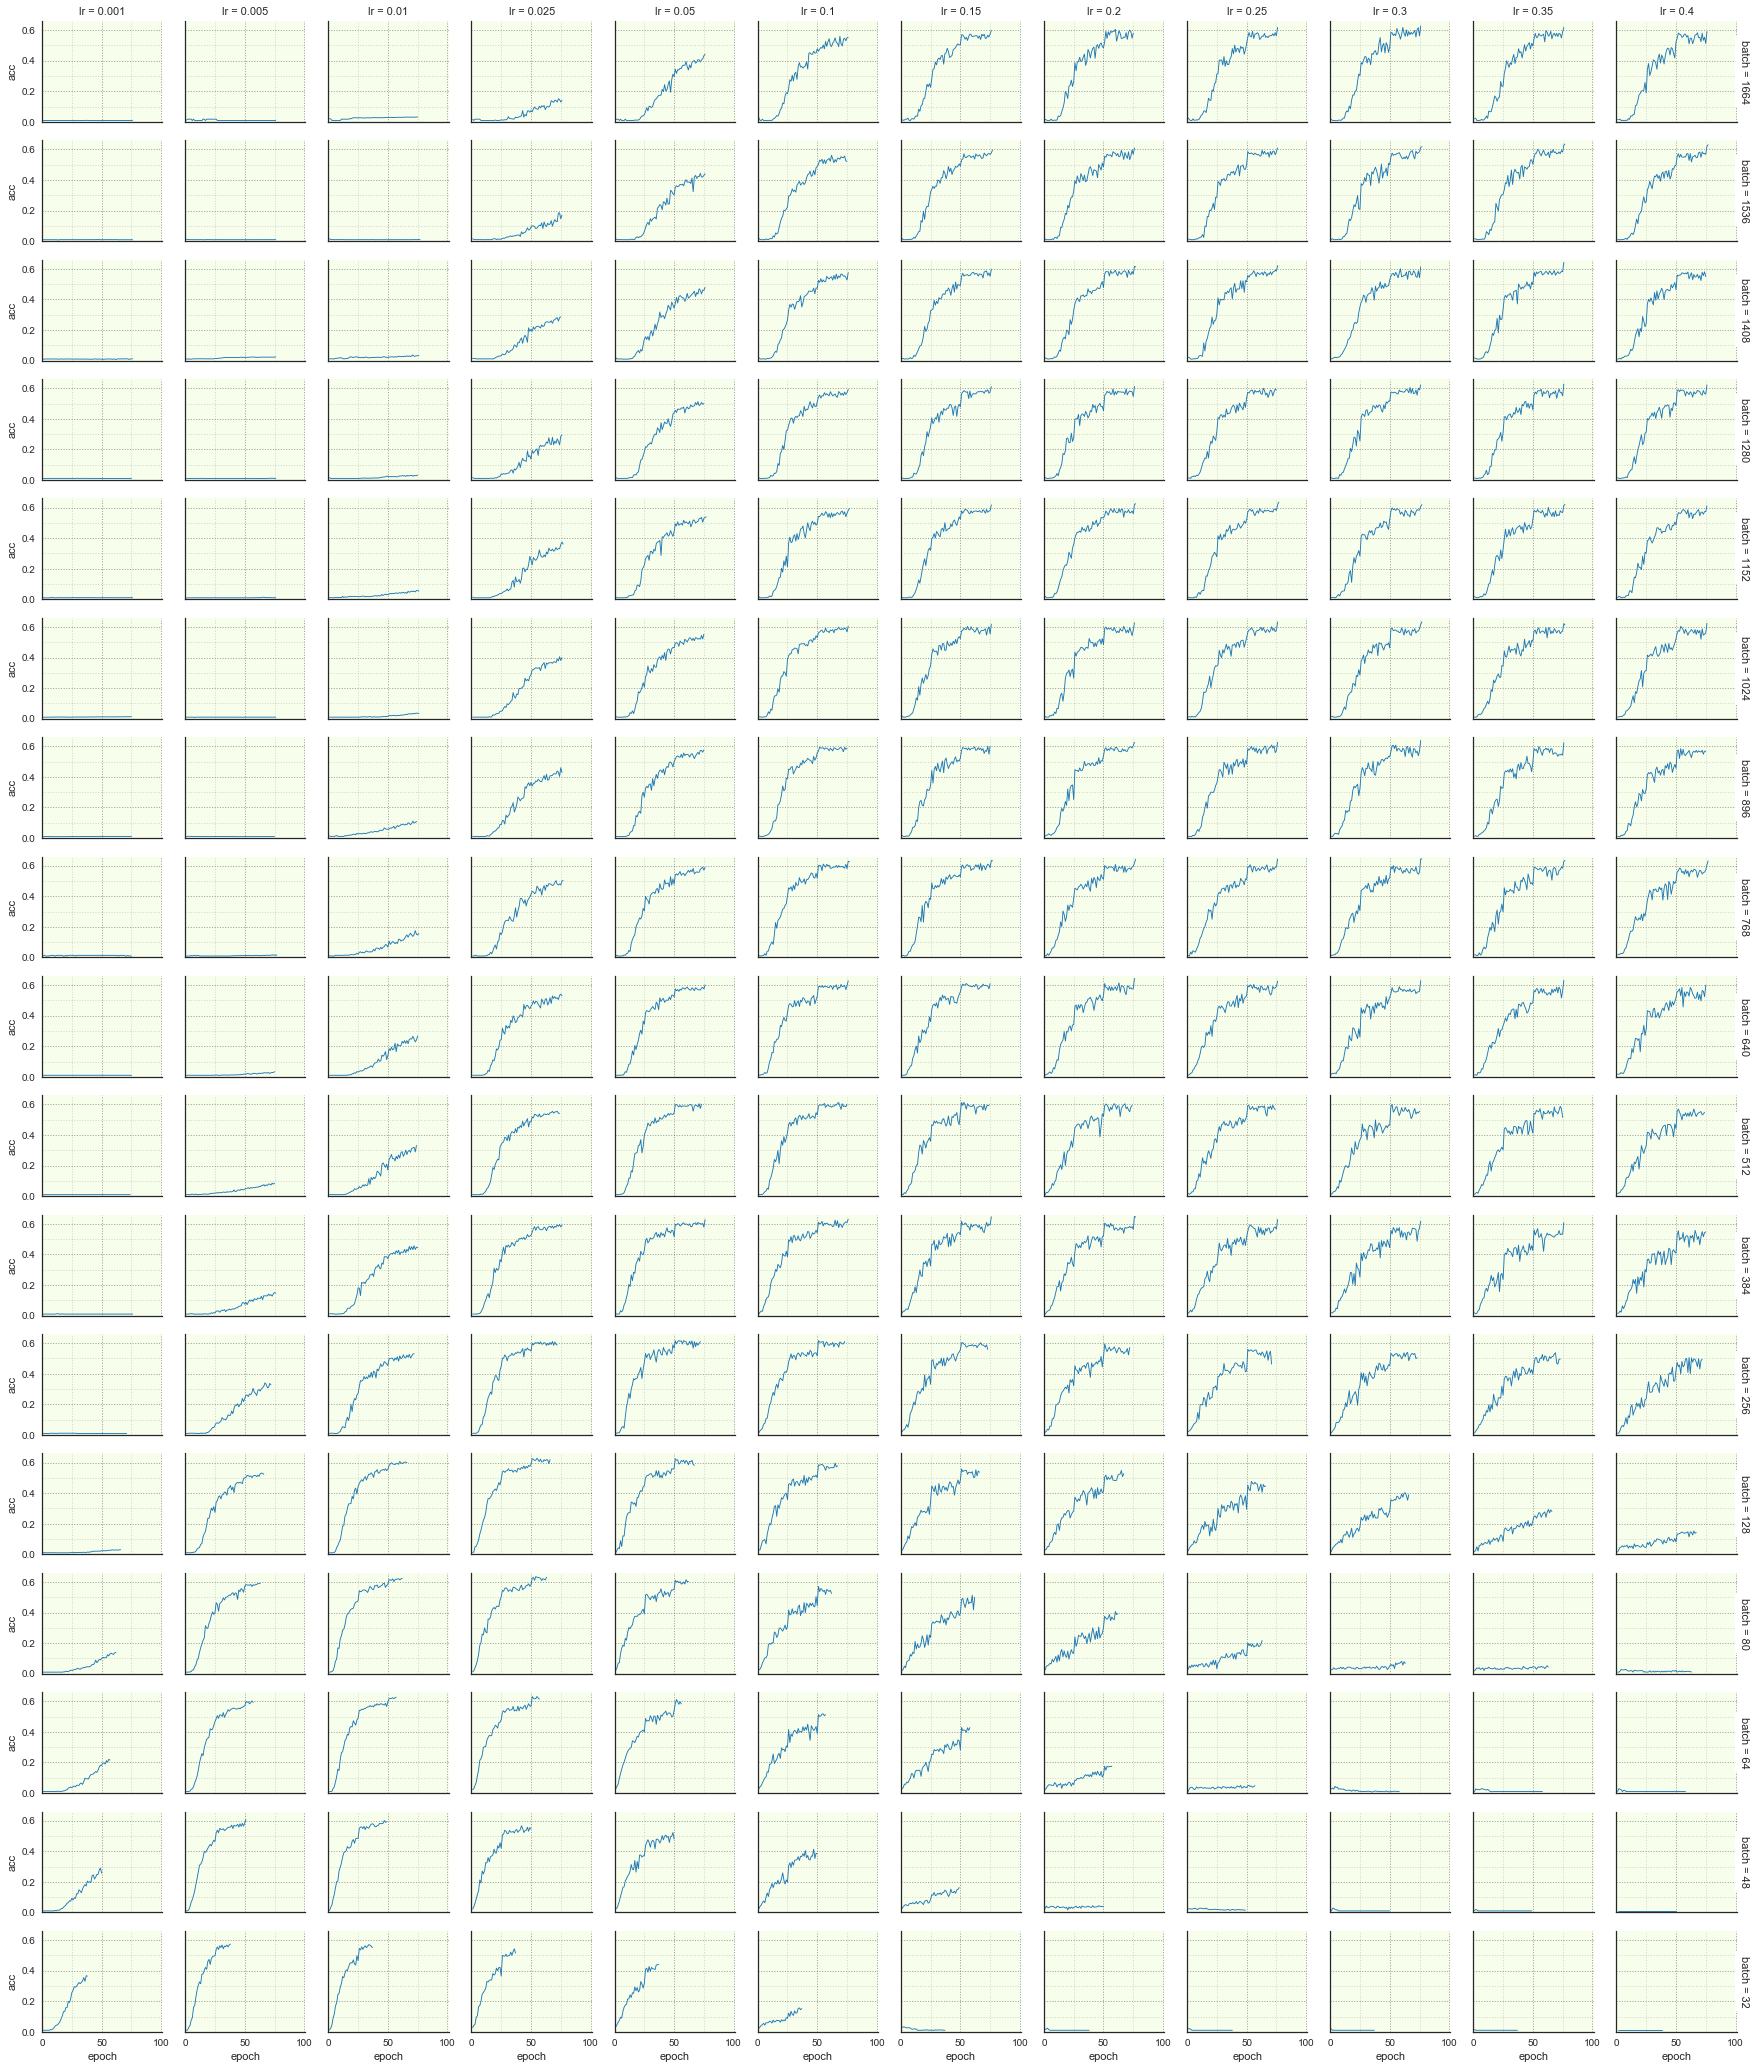

In [182]:
# Plot using Seaborn FacetGrid
# Set Seaborn global parameters
sns.set(font_scale=1)
sns.set_style("white",{'axes.grid': True, 'grid.color': (0,0,0),'grid.linestyle':u':'})
#print sns.axes_style()

major_xticks = np.arange(0,101,50)
minor_xticks = np.arange(0,101,25)
major_yticks = np.arange(0,.61,.2)
minor_yticks = np.arange(0,.61,.1)
with sns.color_palette("tab10"):
    fg = sns.FacetGrid(df,row="batch",col="lr",size=1.7,aspect=1.2,
                         row_order=df.batch.unique(),
                         margin_titles=True,
                         xlim=(0,101),
                         ylim=(0.,.66),
                        subplot_kws={"facecolor":"#F7FEEB"})
    fg.map(plt.plot,"epoch","acc",ls="-",linewidth=.9)
    
    for ax_arr in np.nditer(fg.axes,flags=["refs_ok"]):
        ax = ax_arr.item()
        ax.set_xticks(major_xticks)
        ax.set_yticks(major_yticks)
        ax.set_xticks(minor_xticks, minor=True)        
        ax.set_yticks(minor_yticks, minor=True)
        ax.grid(which="major",ls=":",alpha=0.25, color="black")
        ax.grid(which="minor",ls=":",alpha=0.15, color="black")